## 1. Import libraries

In [3]:
# import argparse
import os
import glob
from collections import defaultdict, Counter
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score


## 2. Filename Parsing

In [4]:
def infer_label_from_filename(fname):
    """
    Return 0 for healthy, 1 for MDD based on filename prefix.
    """
    base = os.path.basename(fname)
    if base.startswith("H_"):
        return 0
    elif base.startswith("MDD_"):
        return 1
    else:
        raise ValueError(f"Cannot infer label from filename: {base}")


def parse_subject_id_from_filename(fname):
    """
    Extract a stable subject/session ID from the GC filename.
    Expect: subject_id patterns should proceed 'EO_seg_' or 'EC_seg_'
    """
    base = os.path.basename(fname)
    name, _ = os.path.splitext(base)  # e.g. 'H_6921143_H S15 EO_seg_1_GCmatrix'

    # Look for EO/EC segment markers
    idx = name.find("EO_seg_")
    if idx == -1:
        idx = name.find("EC_seg_")

    if idx != -1:
        subject_id = name[:idx].rstrip()
        return subject_id

    # Fallbacks if pattern is weird
    tokens = name.split()
    if len(tokens) >= 2:
        return " ".join(tokens[:2])
    else:
        return name


def build_subject_index(file_paths):
    """
    Returns:
      s_to_f: dict {subject_id: [path1, path2, ...]}  # subject to files
      s_to_l: dict {subject_id: 0 or 1} # subject to label
    """
    s_to_f = defaultdict(list)
    s_to_l = {}

    for path in file_paths:
        subj = parse_subject_id_from_filename(path)
        label = infer_label_from_filename(path)

        s_to_f[subj].append(path)

        if subj in s_to_l:
            if s_to_l[subj] != label:
                raise ValueError(f"Conflicting labels for subject {subj}")
        else:
            s_to_l[subj] = label

    return s_to_f, s_to_l


In [5]:
# Check if the logic is correct
data_dir = "../data/raw_data/GC_Matrices"
pattern = "*.npy"
file_paths = glob.glob(os.path.join(data_dir, pattern))
s_to_f, s_to_l = build_subject_index(file_paths)

print(any(v in [1, 0] for v in s_to_l.values()))
print(len(s_to_l) == len(s_to_f))

True
True


In [6]:
count_subjects = Counter()
for label in s_to_l.values():
    count_subjects[label] += 1
print(count_subjects) # File name parsing successfully completed.

Counter({1: 33, 0: 32})


## 3. Subject Level Split ()

In [ ]:
def subject_wise_split(subject_ids, val_frac=0.2, test_frac=0.2, seed=42):
    """
    Split subject IDs into train/val/test lists, subject-wise.
    """
    rng = np.random.RandomState(seed)
    subject_ids = np.array(subject_ids)
    rng.shuffle(subject_ids)

    n = len(subject_ids)
    n_test = int(round(n * test_frac))
    n_val = int(round(n * val_frac))

    test_ids = subject_ids[:n_test]
    val_ids = subject_ids[n_test:n_test + n_val]
    train_ids = subject_ids[n_test + n_val:]

    return list(train_ids), list(val_ids), list(test_ids)


def make_datasets(file_paths, val_frac, test_frac, seed, dataset_cls):
    """
    Build train/val/test Dataset instances from raw file paths.
    """
    subject_to_files, subject_to_label = build_subject_index(file_paths)
    all_subjects = list(subject_to_files.keys())

    train_subj, val_subj, test_subj = subject_wise_split(
        all_subjects, val_frac=val_frac, test_frac=test_frac, seed=seed
    )

    def expand(subj_list):
        paths = []
        subj_ids = []
        for s in subj_list:
            s_files = subject_to_files[s]
            paths.extend(s_files)
            subj_ids.extend([s] * len(s_files))
        return paths, subj_ids
    
    # Paths and subject IDs for each dataset
    train_paths, train_subj_ids = expand(train_subj)
    val_paths, val_subj_ids = expand(val_subj)
    test_paths, test_subj_ids = expand(test_subj)

    # Create Dataset instances
    train_dataset = dataset_cls(train_paths, train_subj_ids, subject_to_label)
    val_dataset = dataset_cls(val_paths, val_subj_ids, subject_to_label)
    test_dataset = dataset_cls(test_paths, test_subj_ids, subject_to_label)

    return train_dataset, val_dataset, test_dataset


In [8]:
# train/val/test split ratio check
sample_split = subject_wise_split(list(s_to_f.keys())[:10])
sample_split # default 6 : 2 : 2

([np.str_('MDD_MDD S10'),
  np.str_('H_H S13'),
  np.str_('MDD_MDD S29'),
  np.str_('H_H S10'),
  np.str_('H_H S20'),
  np.str_('MDD_MDD S27')],
 [np.str_('MDD_MDD S1'), np.str_('H_H S7')],
 [np.str_('MDD_MDD S6'), np.str_('H_H S9')])

In [32]:
def expand(subj_list):
    paths = []
    subj_ids = []
    for s in subj_list:
        s_files = s_to_f[s]
        paths.extend(s_files)
        subj_ids.extend([s] * len(s_files))
    return paths, subj_ids

paths, subj_ids = expand(sample_split[0])
(len(paths) == len(subj_ids))

True

## 4. Dataset Class

In [9]:
class EEGGCDataset(Dataset):
    def __init__(self, file_paths, subject_ids, label_map,
                 log_transform=True, eps=1e-6, diag_zero=True):
        """
        file_paths: list of .npy paths
        subject_ids: list of subject_id strings (same length as file_paths)
        label_map: dict {subject_id: 0 or 1}  (0=healthy, 1=MDD)
        """
        assert len(file_paths) == len(subject_ids)
        self.file_paths = file_paths
        self.subject_ids = subject_ids
        self.label_map = label_map
        self.log_transform = log_transform
        self.eps = eps
        self.diag_zero = diag_zero

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        subj = self.subject_ids[idx]
        y = self.label_map[subj]  # 0 or 1

        # Load p-value GC matrix: (19, 19) or (38, 38)
        gc = np.load(path).astype(np.float32)

        # Transform p-values: p -> -log10(p)
        if self.log_transform:
            gc = -np.log10(gc + self.eps)

        # Remove self-connections
        if self.diag_zero and gc.shape[0] == gc.shape[1]:
            np.fill_diagonal(gc, 0.0)

        # Add channel dimension: (1, H, W)
        gc = np.expand_dims(gc, axis=0)

        x = torch.from_numpy(gc)
        y = torch.tensor(float(y), dtype=torch.float32)

        return x, y, subj


## 5. CNN Model

In [15]:
class GCNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 19 -> 9 (floor)

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 9 -> 4

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Fix spatial size for any input (19x19, 38x38, etc.)
            nn.AdaptiveAvgPool2d((2, 2))           # -> (128, 2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                          # 128 * 2 * 2 = 512
            nn.Linear(128 * 2 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5), #0.75
            nn.Linear(128, 1)                      # binary logit
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(-1)                       # (B,)


## 6. Training & Evaluation Functions

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()           # ← Clear old gradients
        logits = model(x)               # ← Forward pass (model prediction)
        loss = criterion(logits, y)     # ← Compute loss
        loss.backward()                 # ← Backpropagation (compute gradients)
        optimizer.step()                # ← **UPDATE WEIGHTS** using optimizer

        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate_segment_level(model, loader, device):
    model.eval()
    all_logits, all_labels = [], []

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        all_logits.append(logits.cpu())
        all_labels.append(y.cpu())

    all_logits = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy()

    probs = 1.0 / (1.0 + np.exp(-all_logits))
    preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(all_labels, preds)
    try:
        auc = roc_auc_score(all_labels, probs)
    except ValueError:
        auc = float("nan")

    return acc, auc


@torch.no_grad()
def evaluate_subject_level(model, loader, device):
    """
    Aggregate logits per subject (mean), then compute acc & AUC.
    """
    model.eval()
    subj_logits = defaultdict(list)
    subj_labels = {}

    for x, y, subj in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x).cpu().numpy()
        y = y.cpu().numpy()

        for l, label, s in zip(logits, y, subj):
            subj_logits[s].append(l)
            subj_labels[s] = int(label)

    all_probs, all_y = [], []
    for s, logits_list in subj_logits.items():
        mean_logit = np.mean(logits_list)
        prob = 1.0 / (1.0 + np.exp(-mean_logit))
        all_probs.append(prob)
        all_y.append(subj_labels[s])

    all_probs = np.array(all_probs)
    all_y = np.array(all_y)
    preds = (all_probs >= 0.5).astype(int)

    acc = accuracy_score(all_y, preds)
    auc = roc_auc_score(all_y, all_probs)

    return acc, auc


## 7. Main Training Script

#### Model Initialization 
- The weights are randomly initialized in GCNet().__init__()
- The learning rate is set here: lr=args.lr (default: 1e-3)
- weight_decay=args.weight_decay is L2 regularization (default: 1e-4)

#### Weights update
Inside `train_one_epoch()` function in above cell

`optimizer.zero_grad()` ← Clear old gradients <br>
`logits = model(x)` ← Forward pass (model prediction)<br>
`loss = criterion(logits, y)` ← Compute loss<br>
`loss.backward()` ← Backpropagation (compute gradients)<br>
`optimizer.step()` ← **UPDATE WEIGHTS** using optimizer
 

#### Learning Rate Adjustment
`scheduler.step(val_subj_auc)` ← Learning rate is **reduced** if validation AUC plateaus

In [ ]:
def run_training(args):
    # Device
    if args.device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(args.device)

    print(f"Using device: {device}")

    # Visualization purpose
    train_losses = []
    val_seg_aucs = []
    val_subj_aucs = []

    # Seeds
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

    # Files
    pattern = os.path.join(args.data_dir, args.pattern)
    file_paths = sorted(glob.glob(pattern))
    if len(file_paths) == 0:
        raise RuntimeError(f"No files matched {pattern}")

    print(f"Found {len(file_paths)} files.")

    # Datasets
    train_dataset, val_dataset, test_dataset = make_datasets(
        file_paths,
        val_frac=args.val_frac,
        test_frac=args.test_frac,
        seed=args.seed,
        dataset_cls=EEGGCDataset,
    )

    print(f"Train segments: {len(train_dataset)}, "
          f"Val segments: {len(val_dataset)}, "
          f"Test segments: {len(test_dataset)}")

    # Dataloaders
    use_pin_memory = (device.type == "cuda")  # only true on real GPU

    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
        pin_memory=use_pin_memory,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=use_pin_memory,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=use_pin_memory,
    )


    # Model, loss, optimizer, scheduler
    model = GCNet().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr,
                           weight_decay=args.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=5
    )

    best_val_subj_auc = -np.inf
    best_state_dict = None

    for epoch in range(1, args.epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

        val_seg_acc, val_seg_auc = evaluate_segment_level(model, val_loader, device)
        val_subj_acc, val_subj_auc = evaluate_subject_level(model, val_loader, device)

        # Store results
        train_losses.append(train_loss)
        val_seg_aucs.append(val_seg_auc)
        val_subj_aucs.append(val_subj_auc)

        scheduler.step(val_subj_auc)  # ← Learning rate is **reduced** if validation AUC plateaus

        if val_subj_auc > best_val_subj_auc:
            best_val_subj_auc = val_subj_auc
            best_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}

        if epoch % args.log_interval == 0:
            print(
                f"Epoch {epoch:03d} | "
                f"Train loss: {train_loss:.4f} | "
                f"Val seg Acc/AUC: {val_seg_acc:.3f}/{val_seg_auc:.3f} | "
                f"Val subj Acc/AUC: {val_subj_acc:.3f}/{val_subj_auc:.3f}"
            )
        
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch {epoch:03d} | LR: {current_lr:.2e}")


    # Load best model by validation subject-level AUC
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)

    # Final test metrics
    test_seg_acc, test_seg_auc = evaluate_segment_level(model, test_loader, device)
    test_subj_acc, test_subj_auc = evaluate_subject_level(model, test_loader, device)

    print("=== Final Test Metrics ===")
    print(f"Segment-level  Acc: {test_seg_acc:.3f}  AUC: {test_seg_auc:.3f}")
    print(f"Subject-level  Acc: {test_subj_acc:.3f}  AUC: {test_subj_auc:.3f}")

    history = {
        "train_loss": train_losses,
        "val_seg_auc": val_seg_aucs,
        "val_subj_auc": val_subj_aucs,
    }

    return model, history, (test_seg_acc, test_seg_auc, test_subj_acc, test_subj_auc)



## 8. Run code

In [38]:
from types import SimpleNamespace

args = SimpleNamespace(
    # data_dir="../data/raw_data/GC_Matrices", # full dataset
    data_dir="../MLP/sampled_files_200", # use a smaller dataset for testing
    pattern="*.npy",
    epochs=20,
    batch_size=64,
    lr=1e-3,
    weight_decay=1e-4,
    num_workers=0, #4
    val_frac=0.2,
    test_frac=0.2,
    seed=42,
    device="auto",
    log_interval=1,
)

model, history, test_metrics = run_training(args)


Using device: cpu
Found 200 files.
Train segments: 120, Val segments: 44, Test segments: 36
Epoch 001 | Train loss: 0.6780 | Val seg Acc/AUC: 0.591/0.735 | Val subj Acc/AUC: 0.462/0.667
Epoch 001 | LR: 1.00e-03
Epoch 002 | Train loss: 0.6034 | Val seg Acc/AUC: 0.591/0.838 | Val subj Acc/AUC: 0.462/0.762
Epoch 002 | LR: 1.00e-03
Epoch 003 | Train loss: 0.5491 | Val seg Acc/AUC: 0.591/0.861 | Val subj Acc/AUC: 0.462/0.786
Epoch 003 | LR: 1.00e-03


/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  

Epoch 004 | Train loss: 0.5163 | Val seg Acc/AUC: 0.591/0.799 | Val subj Acc/AUC: 0.462/0.714
Epoch 004 | LR: 1.00e-03
Epoch 005 | Train loss: 0.4561 | Val seg Acc/AUC: 0.614/0.844 | Val subj Acc/AUC: 0.462/0.786
Epoch 005 | LR: 1.00e-03
Epoch 006 | Train loss: 0.4199 | Val seg Acc/AUC: 0.659/0.844 | Val subj Acc/AUC: 0.538/0.786
Epoch 006 | LR: 1.00e-03
Epoch 007 | Train loss: 0.3583 | Val seg Acc/AUC: 0.682/0.818 | Val subj Acc/AUC: 0.538/0.810
Epoch 007 | LR: 1.00e-03


/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  

Epoch 008 | Train loss: 0.3152 | Val seg Acc/AUC: 0.841/0.855 | Val subj Acc/AUC: 0.846/0.786
Epoch 008 | LR: 1.00e-03
Epoch 009 | Train loss: 0.2645 | Val seg Acc/AUC: 0.750/0.848 | Val subj Acc/AUC: 0.846/0.810
Epoch 009 | LR: 1.00e-03
Epoch 010 | Train loss: 0.2160 | Val seg Acc/AUC: 0.705/0.846 | Val subj Acc/AUC: 0.692/0.810
Epoch 010 | LR: 1.00e-03
Epoch 011 | Train loss: 0.1428 | Val seg Acc/AUC: 0.750/0.846 | Val subj Acc/AUC: 0.692/0.810
Epoch 011 | LR: 1.00e-03


/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  

Epoch 012 | Train loss: 0.1071 | Val seg Acc/AUC: 0.795/0.859 | Val subj Acc/AUC: 0.846/0.810
Epoch 012 | LR: 1.00e-03
Epoch 013 | Train loss: 0.1103 | Val seg Acc/AUC: 0.795/0.859 | Val subj Acc/AUC: 0.769/0.810
Epoch 013 | LR: 5.00e-04
Epoch 014 | Train loss: 0.0459 | Val seg Acc/AUC: 0.795/0.846 | Val subj Acc/AUC: 0.846/0.857
Epoch 014 | LR: 5.00e-04
Epoch 015 | Train loss: 0.0518 | Val seg Acc/AUC: 0.818/0.863 | Val subj Acc/AUC: 0.846/0.810
Epoch 015 | LR: 5.00e-04


/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  

Epoch 016 | Train loss: 0.0284 | Val seg Acc/AUC: 0.795/0.861 | Val subj Acc/AUC: 0.846/0.810
Epoch 016 | LR: 5.00e-04
Epoch 017 | Train loss: 0.0259 | Val seg Acc/AUC: 0.795/0.861 | Val subj Acc/AUC: 0.846/0.810
Epoch 017 | LR: 5.00e-04
Epoch 018 | Train loss: 0.0230 | Val seg Acc/AUC: 0.818/0.863 | Val subj Acc/AUC: 0.692/0.810
Epoch 018 | LR: 5.00e-04
Epoch 019 | Train loss: 0.0139 | Val seg Acc/AUC: 0.818/0.859 | Val subj Acc/AUC: 0.692/0.810
Epoch 019 | LR: 5.00e-04
Epoch 020 | Train loss: 0.0147 | Val seg Acc/AUC: 0.818/0.859 | Val subj Acc/AUC: 0.692/0.810
Epoch 020 | LR: 2.50e-04
=== Final Test Metrics ===
Segment-level  Acc: 0.667  AUC: 0.771
Subject-level  Acc: 0.769  AUC: 0.810


/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/kakuryu/Desktop/phy188/Project3/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [36]:
print("===== FINAL TEST PERFORMANCE =====")
print(f"Segment-level Accuracy: {test_metrics[0]:.4f}")
print(f"Segment-level AUC:      {test_metrics[1]:.4f}")
print(f"Subject-level Accuracy: {test_metrics[2]:.4f}")
print(f"Subject-level AUC:      {test_metrics[3]:.4f}")


===== FINAL TEST PERFORMANCE =====
Segment-level Accuracy: 0.6667
Segment-level AUC:      0.7709
Subject-level Accuracy: 0.7692
Subject-level AUC:      0.8095


## 9. Visualization

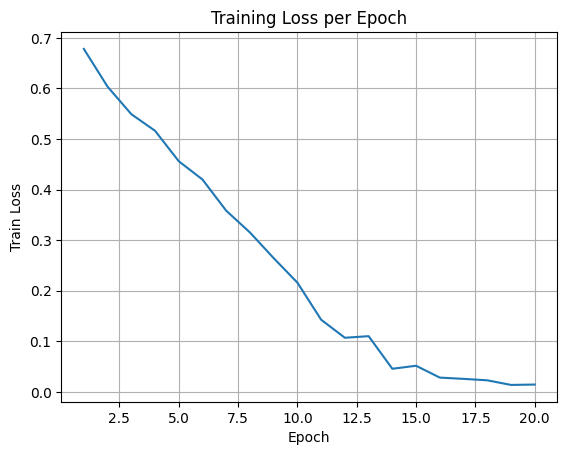

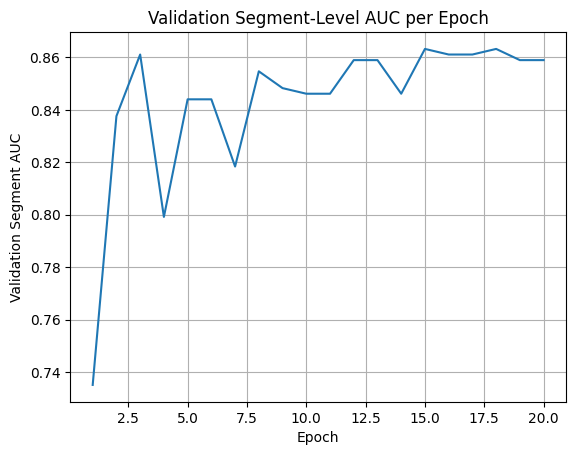

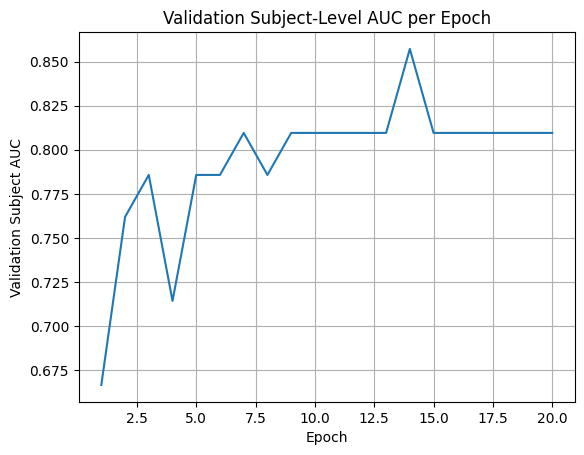

In [17]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(history["train_loss"]) + 1)

# Train Loss 
plt.figure()
plt.plot(epochs, history["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.show()

# Validation Segment-level AUC
plt.figure()
plt.plot(epochs, history["val_seg_auc"])
plt.xlabel("Epoch")
plt.ylabel("Validation Segment AUC")
plt.title("Validation Segment-Level AUC per Epoch")
plt.grid(True)
plt.show()

# Validation Subject-level AUC
plt.figure()
plt.plot(epochs, history["val_subj_auc"])
plt.xlabel("Epoch")
plt.ylabel("Validation Subject AUC")
plt.title("Validation Subject-Level AUC per Epoch")
plt.grid(True)
plt.show()
